# 2022-09-15 • Two-pass connection test: ptp, then corr with found avg

Two-pass connection test: peak-to-peak, then correlation with found average

## Imports

In [1]:
#

In [6]:
using MyToolbox

In [7]:
using VoltoMapSim

## Params

In [12]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [13]:
@time s = cached(sim, [p.sim]);

Loading cached output from `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\ce5e30aee45561ed.jld2` … done (20.2 s)
 25.196100 seconds (12.31 M allocations: 3.040 GiB, 7.48% gc time, 76.01% compilation time: 5% of which was recompilation)


In [14]:
@time s = augment(s, p);

  7.340564 seconds (4.90 M allocations: 293.127 MiB, 5.85% gc time, 97.17% compilation time: 1% of which was recompilation)


## 1. peak-to-peak

We take all inputs with `predicted_type` :exc.

Current pval threshold is 0.05.  
We could be stricter.

It'll be tradeoff: stricter threshold gives less STAs to average to build our template;
but there will be less noisy STAs mixed in (or even wrong STAs, i.e. of non-inputs).

Now
- Get the :exc input detections for neuron 1
- Average their STA
- Apply this template to STAs of all inputs

In [15]:
# But first: cache STAs :)

### Construct 'tested_connections' table

In [16]:
SimData = typeof(s);

In [17]:
function get_tested_connections(s::SimData, p::ExpParams)
    # We do not test all N x N connections (that's too much).
    # The connections we do test are determined by which neurons
    # we record the voltage of, and the `N_tested_presyn` parameter.
    
    tested_connections = DataFrame(
        post     = Int[],     # neuron ID  
        pre      = Int[],     # neuron ID
        conntype = Symbol[],  # :exc or :inh or :unconn
        posttype = Symbol[],  # :exc or :inh
    )
    
    @unpack N_tested_presyn, rngseed = p.conntest
    
    resetrng!(rngseed)
    
    function get_labelled_sample(input_neurons, conntype)
        # Example output: `[(3, :exc), (5, :exc), (12, :exc), …]`.
        N = min(length(input_neurons), N_tested_presyn)
        inputs_sample = sample(input_neurons, N, replace = false, ordered = true)
        zip(inputs_sample, fill(conntype, N))
    end
    
    recorded_neurons = keys(s.v) |> collect |> sort!
    
    for post in recorded_neurons
        
        posttype = s.neuron_type[post]
        
        inputs_to_test = chain(
            get_labelled_sample(s.exc_inputs[post], :exc),
            get_labelled_sample(s.inh_inputs[post], :inh),
            get_labelled_sample(s.non_inputs[post], :unconn),
        ) |> collect
        
        for (pre, conntype) in inputs_to_test
            push!(tested_connections, (; post, pre, conntype, posttype))
        end
    end
    
    return tested_connections
end

tc = get_tested_connections(s, p)

disp(tc, 3)

,post,pre,conntype,posttype
,Int64,Int64,Symbol,Symbol
1,1,139,exc,exc
2,1,681,exc,exc
3,1,11,exc,exc
⋮,⋮,⋮,⋮,⋮


### Calc all STAs

In [18]:
using Base.Threads

function calc_all_STAs(s::SimData, p::ExpParams)
    # Multi-threaded calculation of the real and shuffled STAs of all tested connections.
    #
    # We use a Channel to gather calculations,
    # as inserting items into a Dict is not thread-safe.
    @unpack rngseed, num_shuffles = p.conntest
    tc = tested_connections = get_tested_connections(s, p)
    recorded_neurons = unique(tested_connections.post)
    ch = Channel(Inf)  # `Inf` size, so no blocking on insert
    pbar = Progress(nrow(tested_connections), desc = "Calculating STAs: ")
    @info "Using $(nthreads()) threads"
    @threads(
    for m in recorded_neurons
        v = s.v[m]
        inputs_to_test = tc.pre[tc.post .== m]
        for n in inputs_to_test
            spikes = s.spike_times[n]
            real_STA = calc_STA(v, spikes, p)
            shuffled_STAz = Vector(undef, num_shuffles)  # [1]
            resetrng!(rngseed)
            for i in 1:num_shuffles
                shuffled_spikes = shuffle_ISIs(spikes)
                shuffled_STAz[i] = calc_STA(v, shuffled_spikes, p)
            end
            put!(ch, ((n => m), real_STA, shuffled_STAz))
            next!(pbar)
        end
    end)
    # Empty the channel, into the output dicts
    STAs          = Dict{Pair{Int, Int}, Vector{Float64}}()
    shuffled_STAs = Dict{Pair{Int, Int}, Vector{Vector{Float64}}}()
    while !isempty(ch)
        conn, real, shuffleds = take!(ch)
        STAs[conn]          = real
        shuffled_STAs[conn] = shuffleds
    end
    close(ch)
    
    return (; tested_connections, STAs, shuffled_STAs)
end

# [1] Giving this the same name as the output dict, in combination with `@threads`,
#     confuses type inference and makes it infer `Any` for the `shuffled_STAs` output dict.
#     (That doesn't matter though, as this is a user-facing, top-level function; not an inner-loop one).

calc_all_STAs (generic function with 1 method)

In [19]:
# For 4000 connections tested (0.4% of all) and 100 shuffles,
# we get 404_000 STAs.
# At 1000 Float64 samples per STA, that is 3.2 GB.

In [20]:
# On typing (code_warntype) of calc_all_STAs:
# it didn't matter for timing it was untyped
# (tested with small params `q`, 447 conns).

In [10]:
out = cached(calc_all_STAs, [s,p], key=[p.sim, p.conntest]);

[ Info: Using 7 threads
Calculating STAs: 100%|█████████████████████████████████| Time: 0:19:04
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\calc_all_STAs\b9353bdd11d8b8cb.jld2` … done (18.2 s)


In [21]:
out = cached(calc_all_STAs, [s,p], key=[p.sim, p.conntest]);

Loading cached output from `C:\Users\tfiers\.phdcache\datamodel v2 (net)\calc_all_STAs\b9353bdd11d8b8cb.jld2` … done (48.9 s)


In [22]:
tested_connections, STAs, shuffled_STAs = out;

### Calc pval

In [23]:
Sig = Vector{Float64}

function calc_pval(real_STA::Sig, shuffled_STAs::Vector{Sig}, test_stat)
    real_t      = test_stat(real_STA)
    shuffled_ts = [test_stat(STA) for STA in shuffled_STAs]
    num_shuffled_larger = count(shuffled_ts .> real_t)
    N = length(shuffled_STAs)
    return if num_shuffled_larger == 0
        (pval      = 1/N,
         pval_type = "<")
    else
        (pval      = num_shuffled_larger / N,
         pval_type = "=")
    end
end

calc_pval (generic function with 1 method)

### Test connections

In [25]:
function test_conn__ptp((from,to), STAs, shuffled_STAs; α)
    # α is the p-value threshold.
    pval, _ = calc_pval(STAs[from=>to], shuffled_STAs[from=>to], ptp)
    area = area_over_start(STAs[from=>to])
    if (pval > α)      predtype = :unconn
    elseif (area > 0)  predtype = :exc
    else               predtype = :inh    end
    return (; predtype, pval, area)
end;

test_conn__ptp((from,to); α) = test_conn__ptp((from,to), STAs, shuffled_STAs; α);

In [26]:
test_conn__ptp(139=>1, α = 0.01)

(predtype = :exc, pval = 0.01, area = 0.17)

In [28]:
testresults = 
    @showprogress "Testing connections: " (
    map(eachrow(tested_connections)) do r
        test_conn__ptp(r.pre => r.post, α = 0.01)
    end
);

Testing connections: 100%|██████████████████████████████| Time: 0:00:05


In [29]:
tc = hcat(tested_connections, DataFrame(testresults))
select!(tc, :posttype, :post, :pre, :conntype, :predtype, :pval, :area)
disp(tc, 3)

,posttype,post,pre,conntype,predtype,pval,area
,Symbol,Int64,Int64,Symbol,Symbol,Float64,Float64
1,exc,1,139,exc,exc,0.01,0.17
2,exc,1,681,exc,unconn,0.02,-0.04
3,exc,1,11,exc,exc,0.01,0.18
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


("predtype" is predicted conntype).

We used strict α of 0.01.

Out of interest, what is the T and FPR.

### Detection rates

Previously, we had detection rates per recorded ('post') neuron.
We can also just calculate the rates over the whole table.
Corresponds to the mean of previous notebooks.

In [30]:
detrate(typ) = count((tc.conntype .== typ) .& (tc.predtype .== typ)) / count(tc.conntype .== typ)

(
    TPR_exc = detrate(:exc),
    TPR_inh = detrate(:inh),
    FPR = 1 - detrate(:unconn),
)

(TPR_exc = 0.521, TPR_inh = 0.831, FPR = 0.0785)

We'll use E→E connections for our template.

How many of these did we detect,  
and how many of the detected are false.

In [ ]:
# so we search for [posttype=:exc],
# and then - [conntype=:exc, predtpye=:exc]
#          - [conntype=:unconn, predtype=:exc]

This is *precision*, not TPR (aka accuracy).

### Precision

In [31]:
using DataFramesMeta

In [32]:
df = tc[tc.posttype .== :exc, :]

precision = count((df.predtype .== :exc) .& (df.conntype .== :exc)) / count(df.predtype .== :exc)

0.925

In [33]:
num_EE_detections = count(df.predtype .== :exc)

692

In [34]:
correct_EE_detections = precision * num_EE_detections

640

In [35]:
incorrect_EE_detections = (1 - precision) * num_EE_detections

52

Note that this presumes we know the type of each neuron ('post').

Yeah that's not general.

Let's instead just take all `exc` detected connections, whether or not post is exc or inh.

### ..of *all* detected exc connections

(So also exc→inh)

In [36]:
# sub back df > tc
precision = count((tc.predtype .== :exc) .& (tc.conntype .== :exc)) / count(tc.predtype .== :exc)

0.934

In [37]:
num_exc_detections = count(tc.predtype .== :exc)

845

In [38]:
correct_exc_detections = precision * num_exc_detections

789

In [39]:
incorrect_exc_detections = (1 - precision) * num_exc_detections

56

So to summarize, we detected 52% of true exc connections,  
and 93% of what we detected as exc is actually exc.

## 2. STA template

In [40]:
det_exc_conns = [r.pre=>r.post for r in eachrow(tc) if r.predtype == :exc];

In [78]:
template_ptp = mean(STAs[c] for c in det_exc_conns);

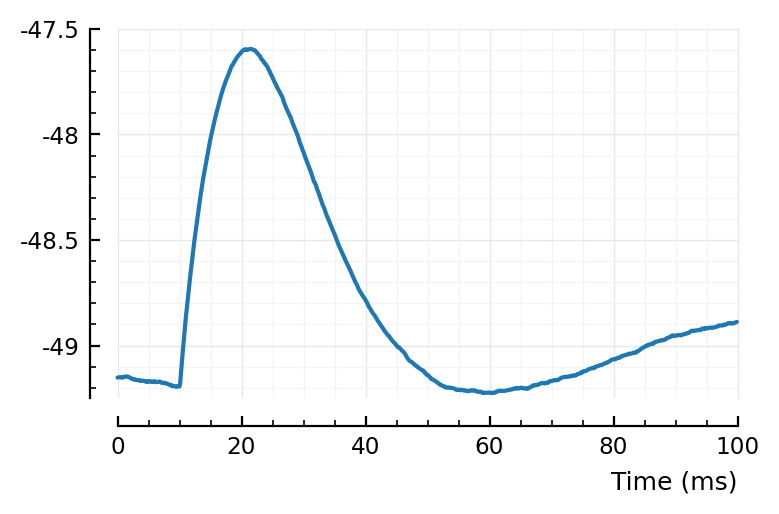

In [79]:
plotsig(template_ptp / mV, p);

In [43]:
# now to corr this, for all conns.

In [77]:
function test_conn__corr((from,to), STAs, shuffled_STAs; α, template)
    # α is the p-value threshold.
    STA = STAs[from=>to]
    corr = cor(STA, template)

    if (corr > 0) test_stat = (STA -> cor(STA, template))
    else          test_stat = (STA -> -cor(STA, template)) end

    pval, _ = calc_pval(STA, shuffled_STAs[from=>to], test_stat)
    if     (pval > α)  predtype = :unconn
    elseif (corr > 0)  predtype = :exc
    else               predtype = :inh end
    return (; predtype, pval, corr)
end
# note: closure of `template`

test_conn__corr((from,to)                     ; α, template = template_ptp) =
test_conn__corr((from,to), STAs, shuffled_STAs; α, template);

In [68]:
function test_conns(testfunc; α)
    testresults = 
        @showprogress "Testing connections: " (
        map(eachrow(tested_connections)) do r
            testfunc(r.pre => r.post; α)
        end)
    
    tc = hcat(tested_connections, DataFrame(testresults))
    
    # Reorder first cols:
    select!(tc, :posttype, :post, :pre, :conntype, :)
    
    num_TP(typ) = count((tc.conntype .== typ) .& (tc.predtype .== typ))
    num_real(typ)     = count(tc.conntype .== typ)
    num_detected(typ) = count(tc.predtype .== typ)
    
    TPR(typ)       = num_TP(typ) / num_real(typ)
    precision(typ) = num_TP(typ) / num_detected(typ)
    
    perf = (
        TPR_exc     = TPR(:exc),
        TPR_inh     = TPR(:inh),
        FPR         = 1 - TPR(:unconn),
        prec_exc    = precision(:exc),
        prec_inh    = precision(:inh),
        prec_unconn = precision(:unconn),
    )
    return (; tc, perf)
end

res = test_conns(test_conn__corr, α = 0.05);

Testing connections: 100%|██████████████████████████████| Time: 0:00:02


Note α = 5% here; in the ptp step, it was the stricter 1%.

In [69]:
res.perf

(TPR_exc = 0.815, TPR_inh = 0.936, FPR = 0.148, prec_exc = 0.899, prec_inh = 0.692, prec_unconn = 0.851)

(Note that TPR no longer broken down by postsynaptic type here. Also, we added precision as performance measure: how much of detected are correct).

## Compare performance

..with just ptp-and-area, now with α = 0.05 too:

In [70]:
res_ptp = test_conns(test_conn__ptp, α = 0.05);

Testing connections: 100%|██████████████████████████████| Time: 0:00:04


To compare with the previous correlation-test-notebook, where we cheated by using the average STA of all a-priori known E→E connections as template, ..

..we used different measure there (calculate detection rates *per postsynaptic neuron*, and then take the median of that. Also these rates were broken down by postsyn type).
The measures here are simpler.

In [86]:
EE_conns = [r.pre=>r.post for r in eachrow(tc) if (r.conntype == :exc) & (r.posttype .== :exc)];

In [87]:
avg_EE_STA = mean(STAs[c] for c in EE_conns);

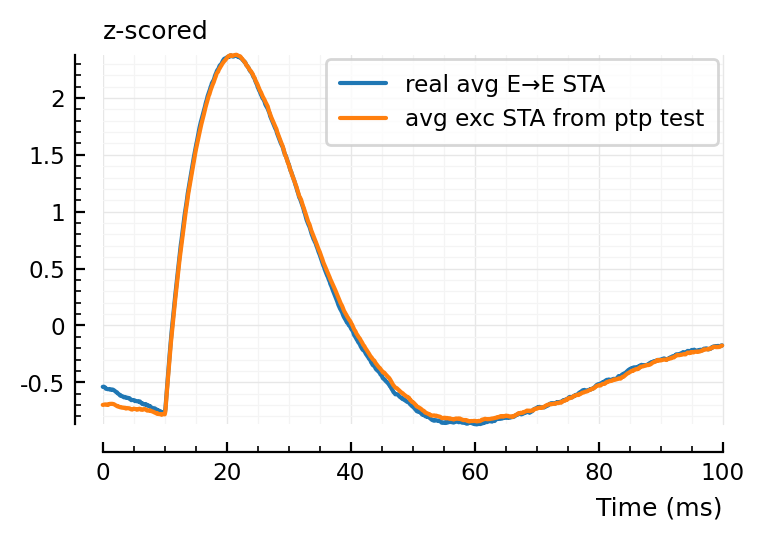

In [104]:
plotsig(zscore(avg_EE_STA), p, label = "real avg E→E STA");
plotsig(zscore(template_ptp), p, label = "avg exc STA from ptp test", hylabel="z-scored")
plt.legend();
# zscore, as ptp template has larger range (hm!)

We should not calc the real E→E STA to compare,  
but rather the E→any STA.

In [93]:
exc_conns = [r.pre=>r.post for r in eachrow(tc) if (r.conntype == :exc)];
avg_exc_STA = mean(STAs[c] for c in exc_conns);

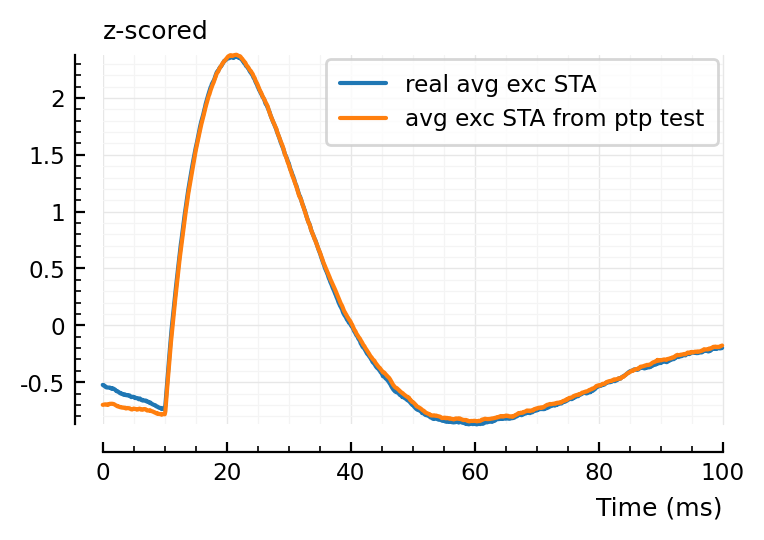

In [103]:
plotsig(zscore(avg_exc_STA), p, label = "real avg exc STA");
plotsig(zscore(template_ptp), p, label = "avg exc STA from ptp test", hylabel="z-scored")
plt.legend();

Not a large difference it seems (not identical either).

Also interesting that the ptp STA has a larger range than the real avg STA:

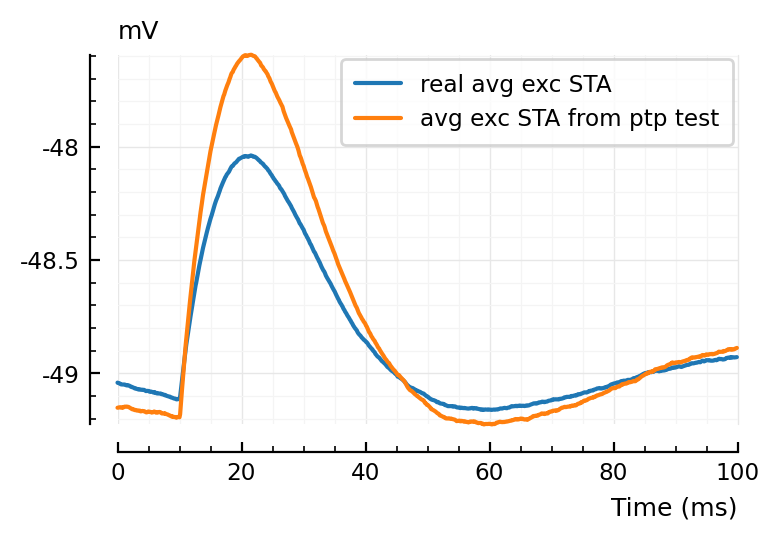

In [102]:
plotsig(avg_exc_STA / mV, p, label = "real avg exc STA");
plotsig(template_ptp / mV, p, label = "avg exc STA from ptp test", hylabel="mV")
plt.legend();

Ah of course: reason why real average STA is smaller, is cause it also includes weaker connections, which the strict ptp test did not pick up.

In [105]:
# Now use this real avg STA as template

testfunc(conn; α) = test_conn__corr(conn; α, template = avg_exc_STA);

res_real_avg = test_conns(testfunc, α = 0.05);

Testing connections: 100%|██████████████████████████████| Time: 0:00:04


In [106]:
res_real_avg.perf

(TPR_exc = 0.815, TPR_inh = 0.936, FPR = 0.147, prec_exc = 0.898, prec_inh = 0.696, prec_unconn = 0.85)

In [107]:
df = DataFrame([
        (; method="ptp only",         res_ptp.perf...),
        (; method="ptp-then-corr",    res.perf...),
        (; method="corr w/ real avg", res_real_avg.perf...),
    ]
);

### Summary table

In [108]:
printsimple(df)

 method            TPR_exc  TPR_inh  FPR    prec_exc  prec_inh  prec_unconn 
────────────────────────────────────────────────────────────────────────────
 ptp only          0.574    0.849    0.145  0.889     0.466     0.772
 ptp-then-corr     0.815    0.936    0.148  0.899     0.692     0.851
 corr w/ real avg  0.815    0.936    0.147  0.898     0.696     0.85

So the two-pass connection test idea works well -- very nearly as well as the 'cheating' test where we correlate with the real average excitatory STA (instead of an average STA found after a first-pass, strict peak-to-peak test).

On what the numbers mean:

`FPR` is how many non-connections were classified as connected.

85% `precision_unconn` means that 15% of what we said was not connected actually was.

---

By also calculating precision (aka positive predictive value) as a performance measure, we see that our high inhibitory detection rates trade-off against a lower precision, compared to excitatory connections.

In [ ]:
using PrettyTab